# Import Libraries

In [2]:
import json
import os
import math
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import seaborn as sns

# Load Data

In [3]:
data_path = 'data_40_512_6.json'
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y

X, y = load_data(data_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

<AxesSubplot:xlabel='Instruments', ylabel='count'>

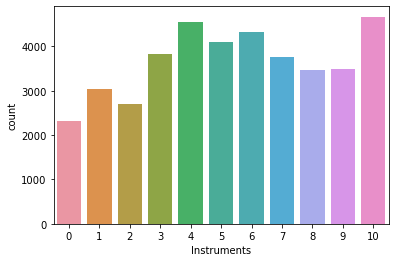

In [4]:
y_df = pd.DataFrame(y, columns = ['Instruments'])
sns.countplot(x = "Instruments", data = y_df)

# Convolutional Neural Network

In [5]:
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)

print(X_test.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(34195, 22, 40)
(34195, 22, 40, 1)
(6035, 22, 40)
(6035, 22, 40, 1)


## Model One

In [6]:
early_stop = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3)

cnn = keras.Sequential()

# Conv. layer 1
cnn.add(keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])))
cnn.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = 'same'))
cnn.add(keras.layers.BatchNormalization())

# Conv. layer 2
cnn.add(keras.layers.Conv2D(64, (3,3), activation = 'relu'))
cnn.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = 'same'))
cnn.add(keras.layers.BatchNormalization())

# Conv. layer 3
#cnn.add(keras.layers.Conv2D(128, (3,3), activation = 'relu'))
#cnn.add(keras.layers.MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same'))
#cnn.add(keras.layers.BatchNormalization())

# Fully Connected
cnn.add(keras.layers.Flatten())

cnn.add(keras.layers.Dense(256, activation = 'relu'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(Dropout(rate = 0.2))

cnn.add(keras.layers.Dense(128, activation = 'relu'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(Dropout(rate = 0.2))

cnn.add(keras.layers.Dense(64, activation = 'relu'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(Dropout(rate = 0.2))

cnn.add(keras.layers.Dense(11, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 38, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 19, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 19, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 17, 64)         36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 9, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 9, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

Epoch 1/10
535/535 [==============================] - 35s 65ms/step - loss: 1.8957 - accuracy: 0.3739 - val_loss: 1.5025 - val_accuracy: 0.4948
Epoch 2/10
535/535 [==============================] - 34s 63ms/step - loss: 1.5052 - accuracy: 0.5013 - val_loss: 1.3873 - val_accuracy: 0.5289
Epoch 3/10
535/535 [==============================] - 34s 63ms/step - loss: 1.3594 - accuracy: 0.5494 - val_loss: 1.2890 - val_accuracy: 0.5604
Epoch 4/10
535/535 [==============================] - 34s 64ms/step - loss: 1.2479 - accuracy: 0.5887 - val_loss: 1.2472 - val_accuracy: 0.5829
Epoch 5/10
535/535 [==============================] - 34s 64ms/step - loss: 1.1589 - accuracy: 0.6177 - val_loss: 1.1500 - val_accuracy: 0.6144
Epoch 6/10
535/535 [==============================] - 34s 64ms/step - loss: 1.0650 - accuracy: 0.6490 - val_loss: 1.1687 - val_accuracy: 0.6083
Epoch 7/10
535/535 [==============================] - 37s 68ms/step - loss: 0.9830 - accuracy: 0.6759 - val_loss: 1.1576 - val_accuracy:

<AxesSubplot:>

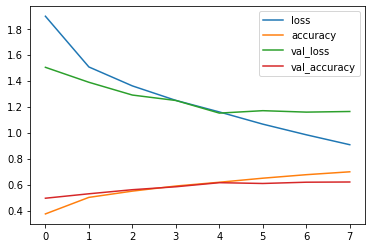

In [7]:
cnn.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks = [early_stop], batch_size = 64, epochs = 10)
loss_history = pd.DataFrame(cnn.history.history)
loss_history.plot()

In [8]:
predict = cnn.predict_classes(X_test)
print(classification_report(y_test,predict))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.62      0.76      0.68       360
           1       0.58      0.60      0.59       463
           2       0.55      0.47      0.51       382
           3       0.58      0.76      0.66       549
           4       0.54      0.64      0.58       741
           5       0.81      0.60      0.69       573
           6       0.66      0.67      0.67       660
           7       0.51      0.45      0.48       550
           8       0.76      0.63      0.69       497
           9       0.54      0.56      0.55       483
          10       0.72      0.65      0.68       777

    accuracy    

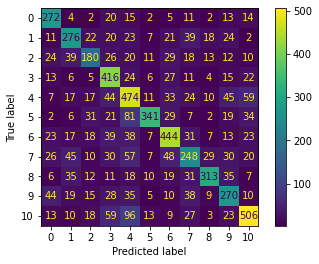

In [9]:
cm = confusion_matrix(y_test, predict)
cm_display = ConfusionMatrixDisplay(cm).plot()

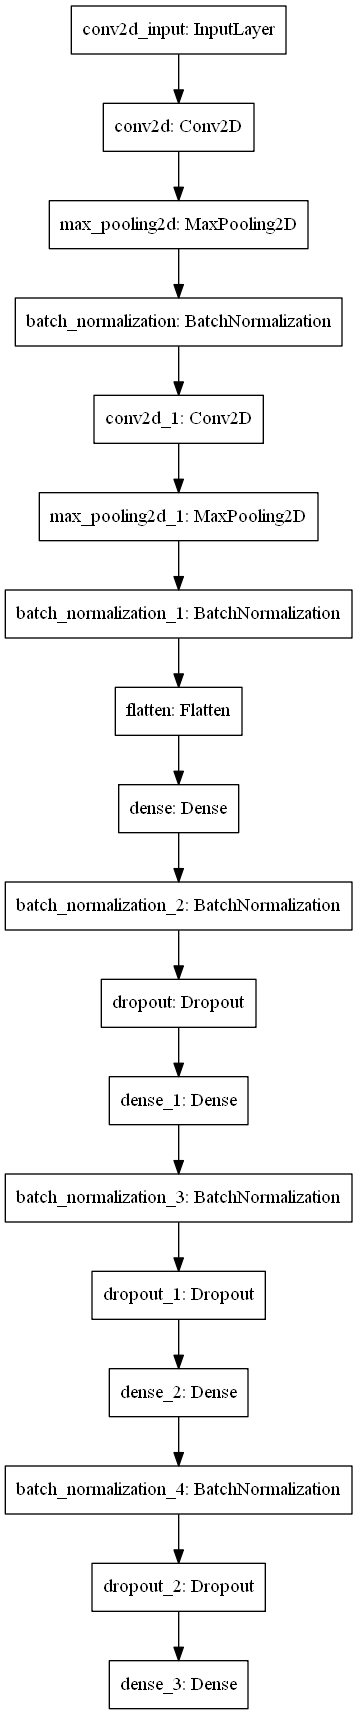

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(cnn)